<a href="https://colab.research.google.com/github/SeharBashir/AI-Powered-Interview-Question-Generator/blob/main/Skin_Lesion_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()  # Upload kaggle.json when prompted


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sehar112","key":"e738ea8c6917e59b44d47cc387584141"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets list -s "ham10000"


ref                                                          title                                                   size  lastUpdated                 downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------  -----------------------------------------------  -----------  --------------------------  -------------  ---------  ---------------  
kmader/skin-cancer-mnist-ham10000                            Skin Cancer MNIST: HAM10000                       5582914511  2018-09-20 20:36:13.037000         218822       2151  0.7058824        
surajghuwalewala/ham1000-segmentation-and-classification     Skin cancer: HAM10000                             2781385274  2021-05-27 09:08:46.813000          16186        126  0.9411765        
tschandl/ham10000-lesion-segmentations                       HAM10000 Lesion Segmentations                       10766207  2020-07-02 21:20:22.710000           1937         33  0.875            
nightfury007/ham10000-isi

In [ ]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000


Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
100% 5.18G/5.20G [01:10<00:00, 155MB/s]
100% 5.20G/5.20G [01:10<00:00, 78.8MB/s]


In [ ]:
!unzip -q skin-cancer-mnist-ham10000.zip -d ham10000


In [ ]:
import os

print("Files in ham10000 directory:")
print(os.listdir("/content/ham10000"))


Files in ham10000 directory:
['hmnist_8_8_L.csv', 'HAM10000_images_part_2', 'ham10000_images_part_2', 'hmnist_28_28_RGB.csv', 'HAM10000_metadata.csv', 'ham10000_images_part_1', 'HAM10000_images_part_1', 'hmnist_28_28_L.csv', 'hmnist_8_8_RGB.csv']


In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split


In [ ]:
# Paths
DATA_DIR = "/content/ham10000"
METADATA_CSV = f"{DATA_DIR}/HAM10000_metadata.csv"

# Load metadata
df = pd.read_csv(METADATA_CSV)
print("Shape:", df.shape)
df.head()


Shape: (10015, 7)


,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [ ]:
# Add full image path
df['path'] = df['image_id'].apply(lambda x: f"{DATA_DIR}/HAM10000_images_part_1/{x}.jpg"
                                  if os.path.exists(f"{DATA_DIR}/HAM10000_images_part_1/{x}.jpg")
                                  else f"{DATA_DIR}/HAM10000_images_part_2/{x}.jpg")

# Map disease labels to readable names
label_map = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}
df['label'] = df['dx'].map(label_map)

df.head()


,lesion_id,image_id,dx,dx_type,age,sex,localization,path,label
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/content/ham10000/HAM10000_images_part_1/ISIC_...,Benign keratosis-like lesions
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/content/ham10000/HAM10000_images_part_1/ISIC_...,Benign keratosis-like lesions
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/content/ham10000/HAM10000_images_part_1/ISIC_...,Benign keratosis-like lesions
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/content/ham10000/HAM10000_images_part_1/ISIC_...,Benign keratosis-like lesions
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/content/ham10000/HAM10000_images_part_2/ISIC_...,Benign keratosis-like lesions


In [ ]:
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
print("Train samples:", len(train_df))
print("Validation samples:", len(val_df))


Train samples: 8012
Validation samples: 2003


In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_gen = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='path',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


Found 8012 validated image filenames belonging to 7 classes.
Found 2003 validated image filenames belonging to 7 classes.


In [ ]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.4)(x)
output = Dense(len(train_gen.class_indices), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
    layer.trainable = False  # freeze base layers for faster training

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,058,538 (15.48 MB)

 Trainable params: 8,967 (35.03 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
EPOCHS = 10  # (You can increase to 15–20 if time allows)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 792s 3s/step - accuracy: 0.6374 - loss: 1.2252 - val_accuracy: 0.6695 - val_loss: 1.1396
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 755s 3s/step - accuracy: 0.6787 - loss: 1.1216 - val_accuracy: 0.6695 - val_loss: 1.1378
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 774s 3s/step - accuracy: 0.6694 - loss: 1.1524 - val_accuracy: 0.6695 - val_loss: 1.1389
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 768s 3s/step - accuracy: 0.6698 - loss: 1.1521 - val_accuracy: 0.6695 - val_loss: 1.1311
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 764s 3s/step - accuracy: 0.6737 - loss: 1.1392 - val_accuracy: 0.6695 - val_loss: 1.1464
Epoch 6/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 772s 3s/step - accuracy: 0.6712 - loss: 1.1514 - val_accuracy: 0.6695 - val_loss: 1.1308
Epoch 7/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 811s 3s/step - accuracy: 0.6758 - loss: 1.1343 - val_accuracy: 0.6695 - val_loss: 1.1462
Epoch 8/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 775s 3s/step - accuracy: 0.6717 - loss: 1.1437 - val_accu

In [ ]:
# Evaluate on validation data
val_loss, val_acc = model.evaluate(val_gen)
print(f"Validation Accuracy: {val_acc*100:.2f}%")


63/63 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - accuracy: 0.6604 - loss: 1.1532
Validation Accuracy: 66.95%


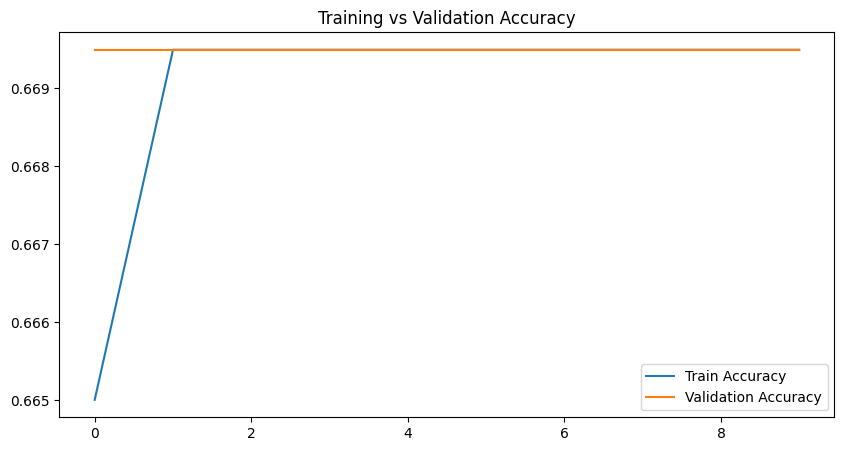

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.show()


Saving lesion.jpeg to lesion (1).jpeg

Testing image: lesion (1).jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


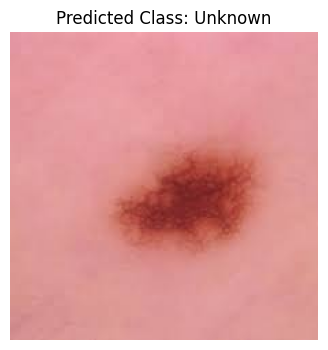

Predicted Class Code: Melanocytic nevi
Predicted Diagnosis: Unknown


In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt
from PIL import Image
import io

# Upload image
uploaded = files.upload()

# Reverse mapping of class indices
labels = {v: k for k, v in train_gen.class_indices.items()}

# Disease name mapping
label_map = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

# Loop through uploaded files
for filename, data in uploaded.items():
    print(f"\nTesting image: {filename}")

    # Load and preprocess the image
    img = Image.open(io.BytesIO(data)).convert("RGB")  # Handles all formats
    img_resized = img.resize((224, 224))
    img_array = np.array(img_resized) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Prediction
    preds = model.predict(img_array)
    predicted_class = np.argmax(preds, axis=1)[0]
    class_code = labels[predicted_class]
    predicted_label = label_map.get(class_code, "Unknown")

    # Display image and prediction
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted Class: {predicted_label}")
    plt.show()

    print(f"Predicted Class Code: {class_code}")
    print(f"Predicted Diagnosis: {predicted_label}")


In [ ]:
model.save("skin_lesion_classifier.keras")
print("Model saved successfully in new Keras format!")



Model saved successfully in new Keras format!
